In [1]:
#------------------------------------------------------------------------------------------------
#  Copyright (c) Shell Global Solutions International B.V. All rights reserved.
#  Licensed under the MIT License. See License.txt in the project root for license information.
#------------------------------------------------------------------------------------------------

# Introduction to simulation of centrifuge experiments using 1D2P

- In this notebook we will simulate a drainage and an imbibition centrifuge experiment.

In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns # we use seaborn to get nice plots (can be left out)
sns.set_style('whitegrid')

In [3]:
import scallib001.relpermlib001 as rlplib # relperm and capillary pressure library

In [4]:
from scallib001.displacementmodel1D2P001 import DisplacementModel1D2P # the solver

In [5]:
from scallib001.utils import dictn, make_movie_schedule

# Centrifuge drainage experiment

We use model data from the centrifuge drainage example in ref [1].

1. COMPARISON OF FOUR NUMERICAL SIMULATORS FOR SCAL EXPERIMENTS, Roland Lenormand, Kjetil Lorentzen, Jos G. Maas and Douglas Ruth, SCA2016-006 https://www.jgmaas.com/SCA/2016/SCA2016-006.pdf

## Relative permeability

We choose the following relperm parameters for the drainage relperm model:

In [6]:
Swc_d = 0.3
Sor_d = 0.0
Nw_d = 3.0
No_d = 2.0
Kew_d = 1.0
Keo_d = 1.0

In [7]:
rlpmodel_d = rlplib.Rlp2PCorey( Sr1=Swc_d, Sr2=Sor_d, N1=Nw_d, N2=No_d, Ke1=Kew_d, Ke2=Keo_d)

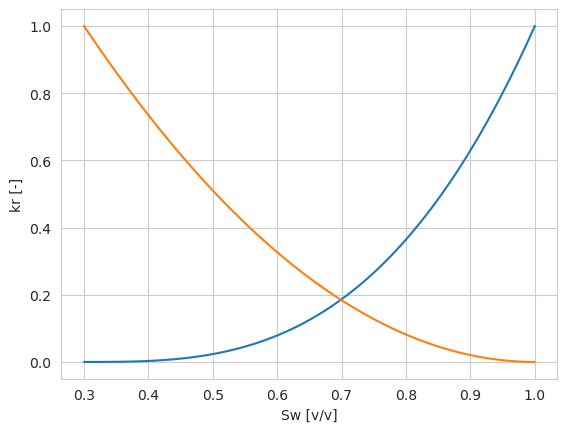

In [8]:
swv = np.linspace(Swc_d, 1-Sor_d, 101)

plt.plot( swv, rlpmodel_d.calc_kr1(swv), label="kr water")
plt.plot( swv, rlpmodel_d.calc_kr2(swv), label="kr water")
plt.xlabel("Sw [v/v]")
plt.ylabel("kr [-]");

## Capillary pressure

In reference [1] a simple capillary pressure model is used:

In [9]:
sw_pc = np.linspace( Swc_d, 1.0, 31)
pc = 0.1033928/(sw_pc - 0.25)

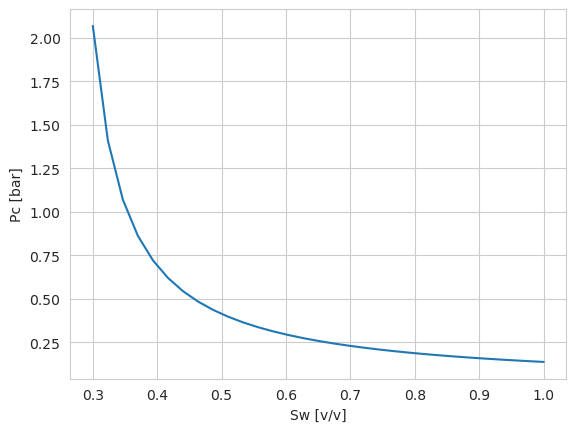

In [10]:
plt.plot( sw_pc, pc )
plt.xlabel("Sw [v/v]")
plt.ylabel("Pc [bar]");

To use this data in the 1D2P solver we define a **monotonic cubic interpolation** model. To help the Newton-Raphson solver we use left and right extrapolation of the Pc curve:

In [11]:
cprmodel_d = rlplib.CubicInterpolator( sw_pc, pc, lex=1, rex=1)

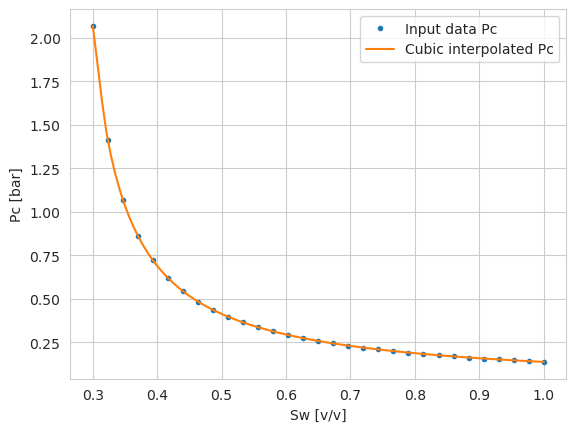

In [12]:
plt.plot( sw_pc, pc, ".", label="Input data Pc")
plt.plot( swv, cprmodel_d.calc(swv)[0], label="Cubic interpolated Pc" )
plt.xlabel("Sw [v/v]")
plt.ylabel("Pc [bar]");
plt.legend();

## Define the time/acceleration schedule for the experiment

We need to specify the start time (in hour) and acceleraton (in meter/second**2) for each centrifuge period; the duration of the experiment is specified separately.

In [13]:
schedule_d = pd.DataFrame(
       [[  0.0,   127.8],  # rpm  200
        [  5.0,   798.9],  # rpm  500
        [ 10.0,  3195.8],  # rpm 1000
        [ 15.0, 12783.1],  # rpm 2000
        [ 20.0, 28762.0],  # rpm 3000
        [ 25.0, 79894.4]], # rpm 5000
       columns=["StartTime", "Acceleration"])

time_end = 30.0 # hour

In [14]:
schedule_d

,StartTime,Acceleration
0,0.0,127.8
1,5.0,798.9
2,10.0,3195.8
3,15.0,12783.1
4,20.0,28762.0
5,25.0,79894.4


Acceleration is related to $\text{rpm}$ via $a = (\frac{ 2 \pi \, \text{rpm}}{60})^2  r_{mid} \,\, [\frac{m}{s^2} ]$ where the mid-plug radius $r_{mid}$ is given in meters.

## Define time at which snapshot will be made of the simulation model results

This time sequence will determine the timestepping of the solver. For smooth solver performance it is important to define a small **start_step_size** (typically 1 second) and a step **increment_factor** that is not too large (typically in the range 1.1 to 1.3).

In [15]:
movie_schedule_d = make_movie_schedule( schedule_d, 
                                        time_end=time_end, # hour
                                        start_step_size=1.0/3600.0, # hour
                                        increment_factor=1.3)

In [16]:
movie_schedule_d

array([2.77777778e-04, 3.61111111e-04, 4.69444444e-04, 6.10277778e-04,
       7.93361111e-04, 1.03136944e-03, 1.34078028e-03, 1.74301436e-03,
       2.26591867e-03, 2.94569427e-03, 3.82940255e-03, 4.97822332e-03,
       6.47169031e-03, 8.41319741e-03, 1.09371566e-02, 1.42183036e-02,
       1.84837947e-02, 2.40289331e-02, 3.12376130e-02, 4.06088970e-02,
       5.27915660e-02, 6.86290359e-02, 8.92177466e-02, 1.15983071e-01,
       1.50777992e-01, 1.96011389e-01, 2.54814806e-01, 3.31259248e-01,
       4.30637022e-01, 5.59828129e-01, 7.27776568e-01, 9.46109538e-01,
       1.22994240e+00, 1.59892512e+00, 2.07860265e+00, 2.70218345e+00,
       3.51283849e+00, 4.56669003e+00, 5.00000000e+00, 5.00027778e+00,
       5.00036111e+00, 5.00046944e+00, 5.00061028e+00, 5.00079336e+00,
       5.00103137e+00, 5.00134078e+00, 5.00174301e+00, 5.00226592e+00,
       5.00294569e+00, 5.00382940e+00, 5.00497822e+00, 5.00647169e+00,
       5.00841320e+00, 5.01093716e+00, 5.01421830e+00, 5.01848379e+00,
      

## Define the simulation model

Compared to the simulation of an USS/SS experiment we need to specify additionally:

- the acceleration_schedule
- the flow_direction, i.e., 'drainage' or 'imbibition'
- the radius of the mid plug position, centrifuge_rmid

In [17]:
model_d = DisplacementModel1D2P(    
    NX             = 100,
    core_length    = 10.0, # cm
    core_area      = np.pi*(4.0/2.0)**2, # cm2
    permeability   = 100.0, # mDarcy
    porosity       = 0.25, # v/v
    sw_initial     = 1.0, # v/v
    viscosity_w    = 1.0, # cP
    viscosity_n    = 5.0, # cP
    density_w      = 1000.0, # kg/m3
    density_n      = 800.0, # kg/m3
    rlp_model      = rlpmodel_d,
    cpr_model      = cprmodel_d,
    time_end       = time_end, # hour
    movie_schedule = movie_schedule_d, # hour
    acceleration_schedule = schedule_d, # hour
    flow_direction = 'drainage',
    centrifuge_rmid = 29.142,  # cm
    max_nr_iter    = 10,
 );

## Simulate the experiment and retrieve results from solver

The first time the solve may take 10s of second because the solver needs to be compiled first by numba.

In [18]:
results_d = model_d.solve().results

Once compiled, the solver is fast, as we can see by using ipython's timeit:

In [19]:
%timeit model_d.solve()

31.2 ms ± 10.9 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


Depending the speed of your computer's CPU, this should take some 10s of milliseonds to complete per simulation.

'results_d'  as returned by the solver is a python dictionary containing simulation results. Conditions at inlet and outlet of the plug (pressure, saturation, flow rates etc) vs time are available in a data frame called 'tss_table'. This is a description of tss_table:

In [20]:
model_d.get_tss_table_info()

,Column,Explanation
0,TIME,"time [hour], start at 0"
1,DTIME,solver time step size taken [hour]
2,PVinj,pore volumes injected [v/v]
3,tD,"dimensionless time, equals PVinj"
4,dtD,solver dimensionless time step size taken [hour]
5,InjRate,total injection volumetric rate [cm3/min]
6,PVInjRate,total injection volumetric rate measured in po...
7,FracFlowInj,fractional flow at inlet [v/v]
8,FracFlowPrd,fractional flow at outlet [v/v]
9,WATERInj,water injection volumetric rate [cm3/min]


Main interest for a centrigue experiment is the average saturation vs time in the plug:

## Average water saturation in the plug vs time

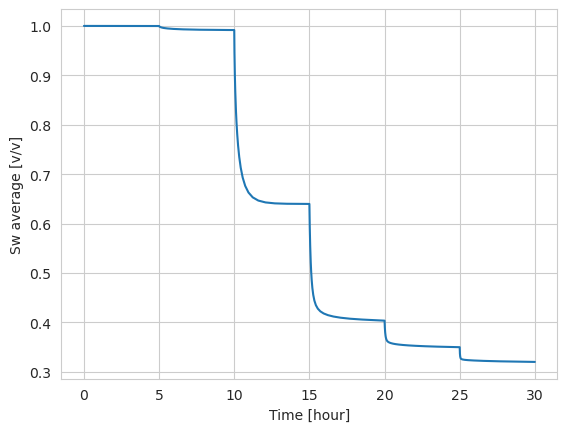

In [21]:
plt.plot( results_d.tss_table.TIME, results_d.tss_table.Sw_avg )
plt.xlabel("Time [hour]")
plt.ylabel("Sw average [v/v]");

## Plot water saturation in the plug vs radius at the start of each period

We can plot data inside the plug vs position at various timesteps. We can use either the **radius** coordinate, which corresponds to the physical layout of the plug in the centrifuge, or a logical **x** coordinate, which runs from inlet of the plug (x=0) to the outlet of the plug (x = length of plug). When using **radius** we will see the draining fluid moving from smaller to larger radius (drainage experiment) and the imbibing fluid moving form larger to smaller radius (imbibition experiment). 1D2P assumes that the density of the wetting fluid (typically water) is larger than that of the non-wetting fluid (typically oil).

We see how oil moves in from left to right and water is displaced outwards.

Snapshots of the 1D model are stored in so-called movie arrays, e.g.,

- movie_time: time of each snapshot [hour]
- movie_period: period number for each snapshot [integer, starting at 1]
- movie_sw: snapshots of wetting saturation
- movie_pw: snapshots of wetting phase pressure [bar]
- movie_pn: snapshots of non-wetting phase pressure [bar]
- movie_pcw: snapshots of wetting capillary pressure [bar]
- movie_flxw: snapshots of wetting phase volumetric flow at each interface [cm3/minute]
- movie_flxn: snapshots of non-wetting phase volumetric flow at each interface [cm3/minute]


In [22]:
periods, period_indices = np.unique(results_d.movie_period, return_index=True)

Plot profile using radius:

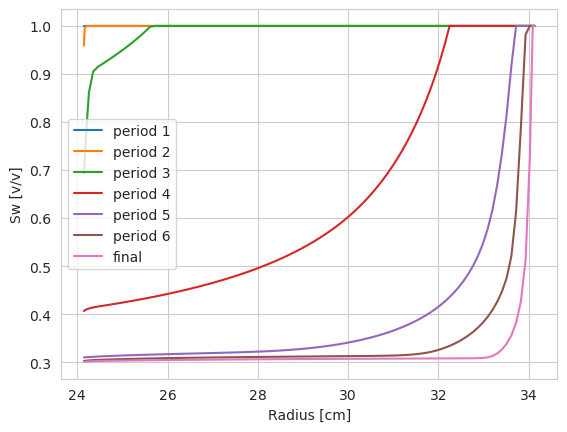

In [23]:
for p, i in zip(periods, period_indices):
    plt.plot( results_d.radius, results_d.movie_sw[i,:], label=f"period {p}" )
plt.plot( results_d.radius, results_d.movie_sw[-1,:], label=f"final" )
plt.ylabel("Sw [v/v]")
plt.xlabel("Radius [cm]")
plt.legend();

Plot vs position in the plug:

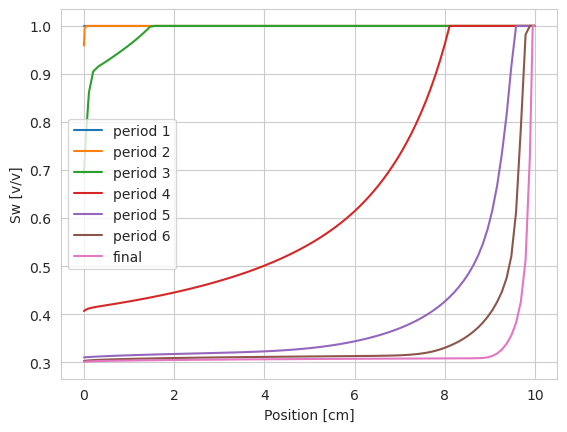

In [24]:
for p, i in zip(periods, period_indices):
    plt.plot( results_d.x, results_d.movie_sw[i,:], label=f"period {p}" )
plt.plot( results_d.x, results_d.movie_sw[-1,:], label=f"final" )
plt.ylabel("Sw [v/v]")
plt.xlabel("Position [cm]")
plt.legend();

## Plot water capillary pressure in the plug vs radius at the start of each period

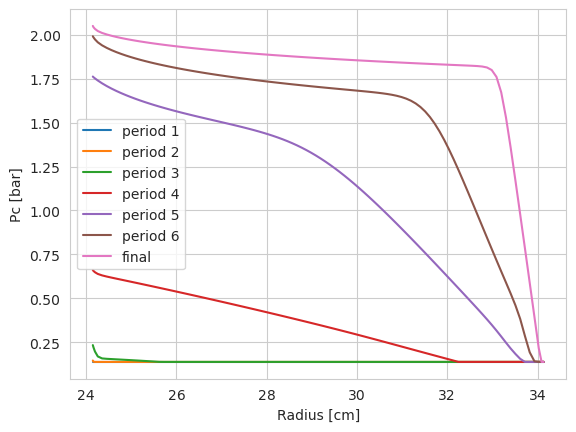

In [25]:
for p, i in zip(periods, period_indices):
    plt.plot( results_d.radius, results_d.movie_pcw[i,:], label=f"period {p}" )
plt.plot( results_d.radius, results_d.movie_pcw[-1,:], label=f"final" )
plt.xlabel("Radius [cm]")
plt.ylabel("Pc [bar]")
plt.legend();

Assess solver performance: Newton-Raphson iterations for each timestep:

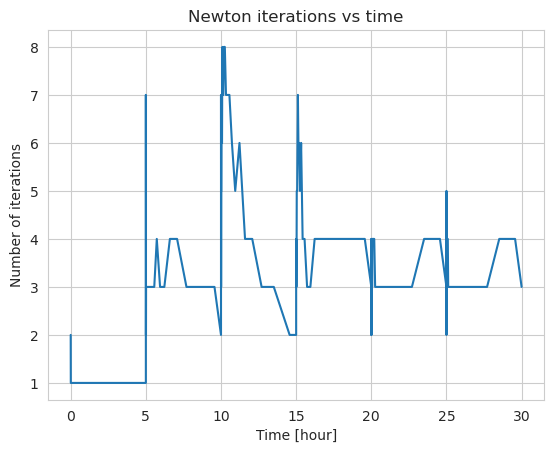

In [26]:
plt.plot( results_d.movie_time, results_d.movie_nr )
plt.xlabel("Time [hour]")
plt.ylabel("Number of iterations");
plt.title("Newton iterations vs time");

#  Centrifuge imbibition experiment

## Define a Corey relperm model

In [27]:
Swc_i = 0.073
Sorw_i = 0.065
Nw_i = 3.8
Now_i = 3.8
Kew_i = 0.8
Keo_i = 0.5

In [28]:
rlpmodel_i = rlplib.Rlp2PCorey( Sr1=Swc_i, Sr2=Sorw_i, N1=Nw_i, N2=Now_i, Ke1=Kew_i, Ke2=Keo_i) 

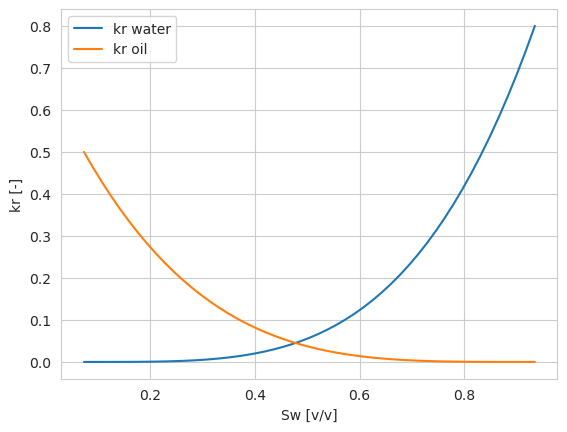

In [29]:
swv = np.linspace(Swc_i, 1-Sorw_i, 51)
plt.plot( swv, rlpmodel_i.calc_kr1(swv), label="kr water" )
plt.plot( swv, rlpmodel_i.calc_kr2(swv), label="kr oil" )
plt.xlabel("Sw [v/v]")
plt.ylabel("kr [-]");
plt.legend();

## Define imbibition Pc using the Skjaeveland model

We first define a function to calculate the Skjaeveland Pc correlation. We choose to impose the spontaneous saturation value and match this by adjusting the weight of the water branch of the Pc ($c_w$).

In [30]:
class Skjaeveland:
    
    def __init__(self, Swc=None, Sorw=None, Swi=None, aw=None, ao=None, co=None):
        
        self.Swc  = Swc
        self.Sorw = Sorw
        self.Swi  = Swi
        self.aw   = aw
        self.ao   = ao
        self.co   = co

        # Adjust strength of water branch to match Swi
        ssw = (  Swi-Swc )/(1-Swc )
        sso = (1-Swi-Sorw)/(1-Sorw)
        cw = - co*np.power(ssw,aw)/np.power(sso,ao)
        
        self.cw = cw
        
    def calc(self,swv):
        Swc  = self.Swc
        Sorw = self.Sorw

        sov = 1-swv
        ssw = (swv-Swc )/(1-Swc )
        sso = (sov-Sorw)/(1-Sorw)
    
        pc1 = self.cw/np.power(ssw,self.aw)
        pc2 = self.co/np.power(sso,self.ao) 
        
        return pc1 + pc2

We will use these parameters for the correlation:

In [31]:
co_i = -0.046046  # bar
aw_i = 0.90
ao_i = 1.65
Sw_i = 0.30  # the spontaneous imbibition saturation

In [32]:
cprmodel  = Skjaeveland( Swc=Swc_i,
                         Sorw=Sorw_i,
                         Swi=Sw_i,
                         aw=aw_i,
                         ao=ao_i,
                         co=co_i,
                       )

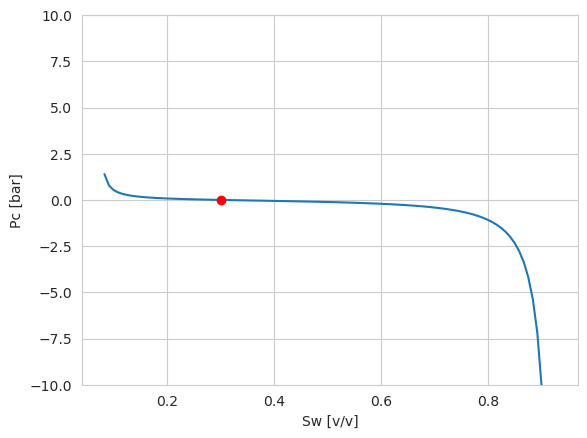

In [33]:
swv = np.linspace(Swc_i+0.01, 1-Sorw_i-0.01, 101)

plt.plot(swv, cprmodel.calc(swv))
plt.plot([Sw_i], [0.0], "ro", label="Swi")
plt.ylim(-10, 10)
plt.ylabel("Pc [bar]")
plt.xlabel("Sw [v/v]");

The red dot in the plot above indicates the spontaneous imbibition point, which is taken as the initial condition for the imbibition experiment.

For use in 1D2P, we interpolate the model using a monotonic cubic spline

In [34]:
cprmodel_i = rlplib.CubicInterpolator( swv, cprmodel.calc(swv), lex=1, rex=1 )

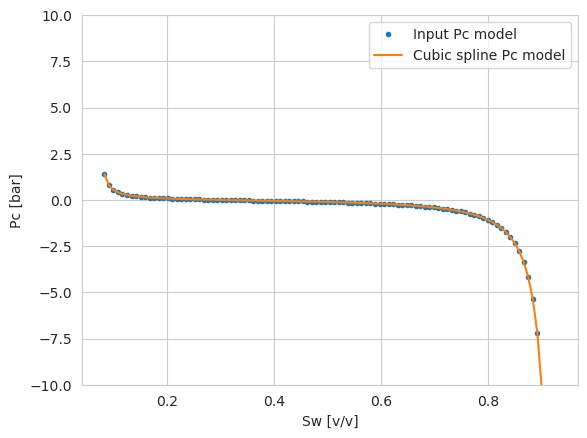

In [35]:
swv = np.linspace(Swc_i+0.01, 1-Sorw_i-0.01, 101)

plt.plot(swv, cprmodel.calc(swv), ".", label="Input Pc model")
plt.plot(swv, cprmodel_i.calc(swv)[0], label="Cubic spline Pc model")
plt.ylim(-10, 10)
plt.ylabel("Pc [bar]")
plt.xlabel("Sw [v/v]");
plt.legend();

## Give the time/acceleration schedule for the experiment

In [36]:
schedule_i = pd.DataFrame( 
     [[  0.00,   843.7],
      [ 48.00,  1499.9],
      [ 99.33,  2343.6],
      [147.30,  3374.8],
      [193.20,  5999.6],
      [240.10,  9374.4],
      [288.10, 18373.8],
      [312.10, 37497.6],
      [330.90, 84369.7],
      [378.90, 181488.6]],
      columns = ["StartTime", "Acceleration"] )

In [37]:
time_end = 410.0 # hour

## Define time at which snapshot will be made of the model results

In [38]:
movie_schedule_i = make_movie_schedule( schedule_i, 
                                      time_end, # hour
                                      start_step_size=1/3600.0, # hour
                                      increment_factor=1.3 )

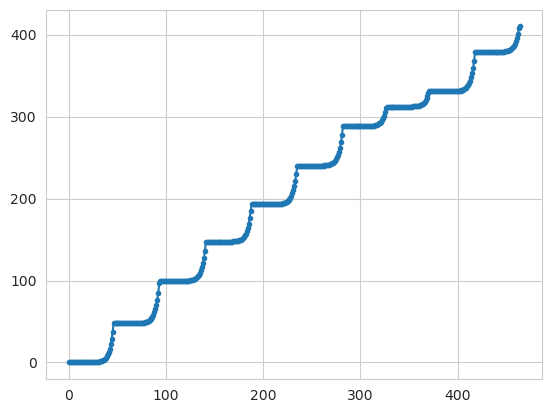

In [39]:
plt.plot( movie_schedule_i, ".-" )

## Define the simulation model

In [40]:
model_params = dictn(
     NX                 =        50,   
     core_length        =     4.905,   # cm
     core_area          =     11.26,   # cm2
     permeability       =      25.3,   # mdarcy
     porosity           =     0.292,   # v/v
     sw_initial         =      Sw_i,   # v/v
     viscosity_w        =     0.426,   # cP
     viscosity_n        =       1.4,   # cP
     density_w          =    1098.0,   
     density_n          =     782.0,   
     rlp_model          = rlpmodel_i,
     cpr_model          = cprmodel_i,
     acceleration_schedule = schedule_i,
     centrifuge_rmid    =   13.6775,   # cm
     flow_direction     = 'imbibition',
     time_end           =     410.0,   # hour
     movie_schedule     = movie_schedule_i,   
     max_nr_iter        =        10,   
     nr_tolerance       =      1e-7,
)

In [41]:
sns_modeli = DisplacementModel1D2P(**model_params)

## Simulate the experiment and get results

In [42]:
results_i = sns_modeli.solve().results

In [43]:
%timeit sns_modeli.solve()

60 ms ± 2.15 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


## Average saturation in the plug vs time

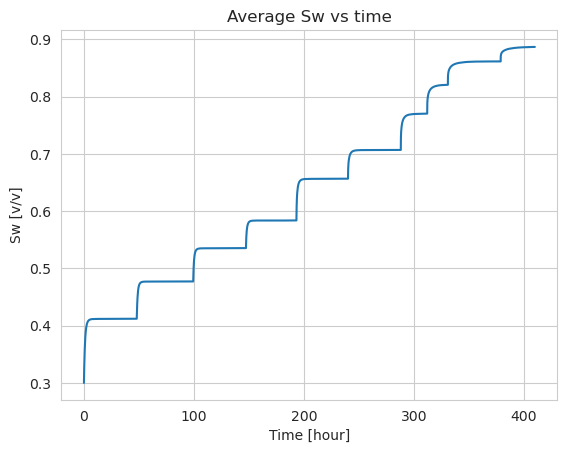

In [44]:
plt.plot( results_i.tss_table.TIME, results_i.tss_table.Sw_avg, label="1D2P");
plt.xlabel("Time [hour]");
plt.ylabel("Sw [v/v]");
plt.title("Average Sw vs time");

## Plot water saturation in the plug vs radius at the start of each period

In [45]:
periods, period_indices = np.unique(results_i.movie_period, return_index=True)

As function of centrifuge radius:

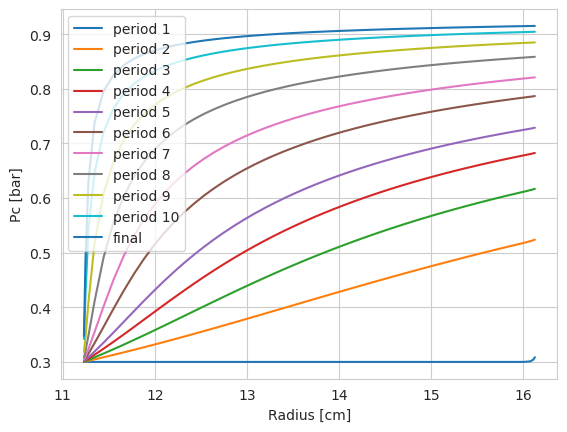

In [46]:
for p, i in zip(periods, period_indices):
    plt.plot( results_i.radius, results_i.movie_sw[i,:], label=f"period {p}" )
plt.plot( results_i.radius, results_i.movie_sw[-1,:], label=f"final" )
plt.xlabel("Radius [cm]")
plt.ylabel("Pc [bar]")
plt.legend();

As function of position in plug:

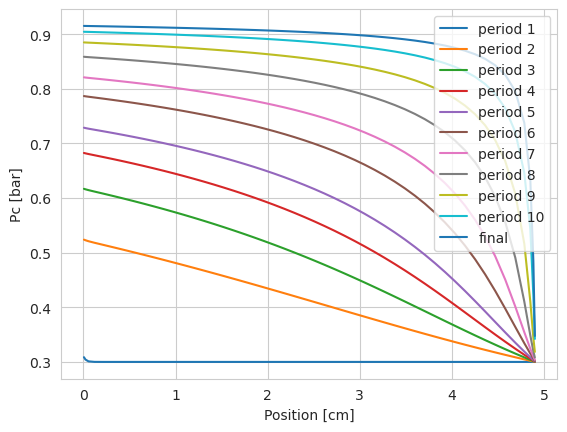

In [47]:
for p, i in zip(periods, period_indices):
    plt.plot( results_i.x, results_i.movie_sw[i,:], label=f"period {p}" )
plt.plot( results_i.x, results_i.movie_sw[-1,:], label=f"final" )
plt.xlabel("Position [cm]")
plt.ylabel("Pc [bar]")
plt.legend();

Plot saturation profile at each timestep and color by period:

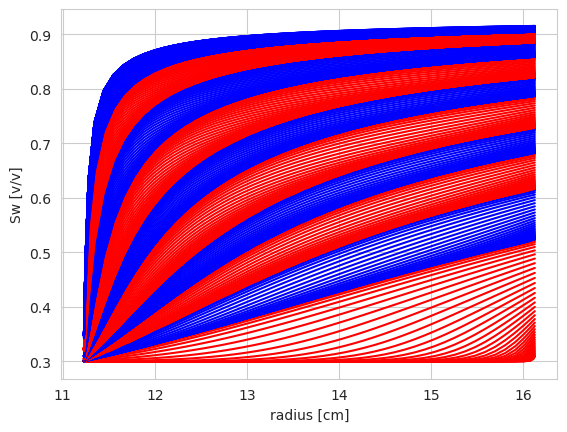

In [48]:
for period in np.unique(results_i.movie_period):
    for sw in results_i.movie_sw[results_i.movie_period==period]:
        plt.plot( results_i.radius, sw, color="r" if period%2 else "b" )

plt.xlabel("radius [cm]");
plt.ylabel("Sw [v/v]");

Pressure at inner and outer radius in the plug vs time:

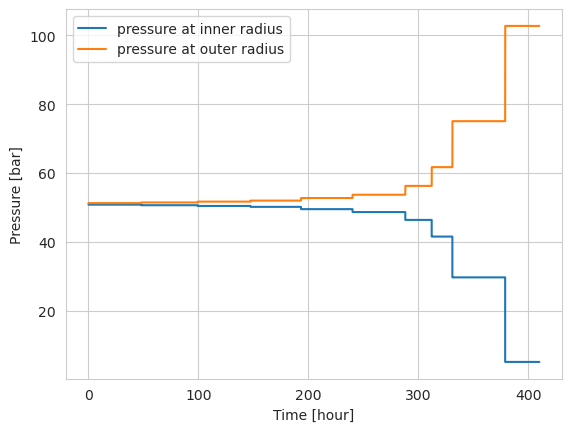

In [49]:
plt.plot( results_i.movie_time, results_i.movie_pw[:,-1], label="pressure at inner radius" )
plt.plot( results_i.movie_time, results_i.movie_pw[:, 0], label="pressure at outer radius" )
plt.legend()
plt.xlabel("Time [hour]")
plt.ylabel("Pressure [bar]");

Assess solver performance: number of Newton-Raphson iterations per timestep.

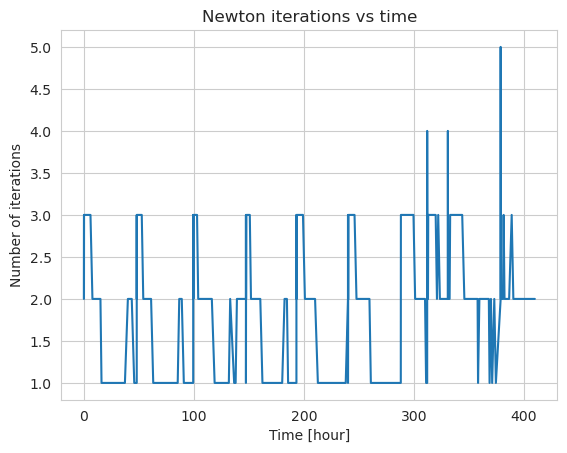

In [50]:
plt.plot( results_i.movie_time, results_i.movie_nr )
plt.xlabel("Time [hour]")
plt.ylabel("Number of iterations");
plt.title("Newton iterations vs time");